In [1]:
import os
%pwd

'd:\\Artificial Intelligence and Machine Learning\\End2End Projects\\chicken-disease-classification\\research'

In [2]:
os.chdir("../")
%pwd

'd:\\Artificial Intelligence and Machine Learning\\End2End Projects\\chicken-disease-classification'

In [3]:
import tensorflow as tf

In [39]:
## Update the entity
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen = True)
class ModelEvaluationConfig:
    model_path: Path
    evaluation_data: Path
    all_params: dict
    params_image_size: list
    params_batch_size: int

In [40]:
## Update the configuration

from cnnclassifier.constants import *
from cnnclassifier.utils.common import *
import matplotlib.pyplot as plt
import numpy as np

In [41]:
class ConfigurationManager:
    def __init__(self, 
                config_filepath = CONFIG_FILE_PATH, 
                secret_filepath = SECRET_FILE_PATH,
                params_filepath = PARAMS_FILE_PATH):
        
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.secret = read_yaml(secret_filepath)

        create_directories_files([self.config.artifacts_root])

    def get_evaluation_config(self)-> ModelEvaluationConfig:
        config = self.config.model_evaluation

        model_eval_config = ModelEvaluationConfig(model_path=config.model_path, 
                                                  evaluation_data = config.evaluation_data,
                                                  all_params= self.params,
                                                  params_image_size = self.params.input_shape,
                                                  params_batch_size = self.params.batch_size
                                                  )
        
        return model_eval_config

In [42]:
## Update the components

class Evaluation:
    def __init__(self, config: ModelEvaluationConfig):
        self.config = config
    
    def _valid_generator(self):
        datagenerator_kwargs = dict(rescale = 1./255, 
                                    validation_split = 0.3)
        
        dataflow_kwargs = dict(target_size = self.config.params_image_size[:-1], 
                               batch_size = self.config.params_batch_size,
                               interpolation = "bilinear")
        
        valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(**datagenerator_kwargs)

        self._valid_generator = valid_datagenerator.flow_from_directory(directory = self.config.evaluation_data, 
                                                                        subset = "validation", shuffle = True, 
                                                                        **dataflow_kwargs)
        
    
    @staticmethod
    def load_model(path: Path) -> tf.keras.Model:
        return tf.keras.models.load_model(path)
    

    def evaluation(self):
        self.model = self.load_model(self.config.model_path)
        self._valid_generator()
        self.score = self.model.evaluate(self._valid_generator)

    def save_score(self):
        loss, accuracy, precision, recall = self.score[0], self.score[1], self.score[2], self.score[3]
        scores = {"loss": loss, "accuracy": accuracy, "precision": precision, "recall": recall}
        save_json(path = Path("scores.json"), data = scores)

    def display_images_with_prediction(self, num_images = 10, title_fontsize = 8):
        images, labels = next(self._valid_generator)
        num_images = min(num_images, len(images))
        predictions = self.model.predict(images)

        predicted_labels = np.argmax(predictions, axis = 1)
        original_labels = np.argmax(labels, axis = 1)

        ##Extracting class labels
        class_labels = list(self._valid_generator.class_indices.keys())

        plt.figure(figsize = (10,10))
        for i in range(num_images):
            plt.subplot(5,5,i+1)
            plt.imshow(images[i])
            plt.title(f"True: {class_labels[original_labels[i]]}\nPred: {class_labels[predicted_labels[i]]}", 
                      fontsize = title_fontsize)
            plt.axis("off")
        plt.tight_layout()
        plt.show()

        

        




[2024-09-05 13:47:24,073: INFO : common : config\config.yaml loaded successfully]
[2024-09-05 13:47:24,077: INFO : common : params\params.yaml loaded successfully]
[2024-09-05 13:47:24,079: INFO : common : secrets\secrets.yaml loaded successfully]
[2024-09-05 13:47:24,080: INFO : common : Parent Directories and Files Successfully Created]
Found 2415 images belonging to 8 classes.
302/302 [==============================] - 19s 59ms/step - loss: 0.5047 - accuracy: 0.9478 - precision: 0.9512 - recall: 0.9445
[2024-09-05 13:47:43,859: INFO : common : Json File saved to path: scores.json]
[2024-09-05 13:47:44,047: WARNING : def_function : 5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025A94E4F700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensor

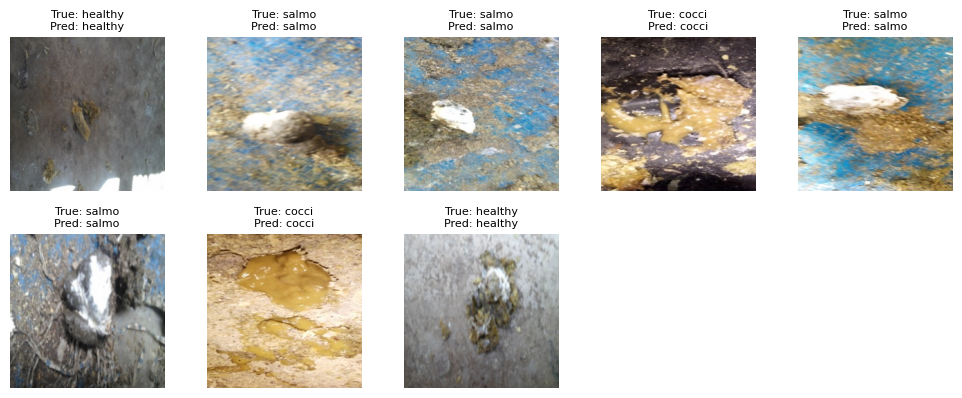

In [43]:
try:
    config = ConfigurationManager()
    eval_config = config.get_evaluation_config()
    evaluation = Evaluation(eval_config)
    evaluation.evaluation()
    evaluation.save_score()
    evaluation.display_images_with_prediction()

except Exception as e:
    raise e
    